### Notebook to analyze total volume transport as a function of depth and latitude to assess transport drifts in the Drake Passage in preindustrial control (piControl) simulations in GFDL models at model's x coordinate to 69W in the Southern Ocean.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import matplotlib.path as mpath
import glob
import os

from dask.distributed import Client 
from dask.distributed import LocalCluster 
cluster = LocalCluster()
client = Client(cluster) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 503.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44949,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 503.02 GiB
Comm: tcp://127.0.0.1:45307,Total threads: 4
Dashboard: http://127.0.0.1:37369/status,Memory: 125.75 GiB
Nanny: tcp://127.0.0.1:42818,


In [2]:
def preprocess(ds):
    '''slice in the yh_sub02 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub02=slice(10,144))
    return dsnew

## Load model output for GFDL high-res configurations
#### __Odiv-183__: p125, c192. Remap scheme PPM_H4 initialized from year 0. Sea ice initial conditions based on year 100 of v3 rather than year 150.
#### __Odiv-184__: p125, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-170__: p25, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-191__: p125, c192. Initialized like Odiv-183/184, remap scheme = P1M_H2, submeso MLE decay time = 10 days. Used as baseline experiment to then tune submeso.
#### __Odiv-200__: p125, c192. Sensitivity of submeso parameterization, submeso MLE decay time = 20 days, with everything else the same as Odiv-191
#### __Odiv-206__: p125, c192. Sensitivity experiment with CM4.0 sea ice albedos initialized from year 180 of Odiv-200 run. 
#### __Odiv-207__: p125, c192. Sensitivity experiment with same sea ice albedos as Odiv-206 but with ESM4 snow-on-land albedos values.

#####
##### Note: A longer MLE decay time means the submeso MLE scheme hangs around longer to __more strongly effect restratification__. We adjusted to T=20 days (doubled the decay time) from Odiv-191 to Odiv-200 because we wanted stronger ML restratification to cool the model since we are running an 1850 piControl. In CM4-CMIP6, MLE T=30 days. Another "tunable" submesoscale parameter is MLE front-length scale ... a __smaller__ front length enhances the strength of the ML restratificaion. ESM4 used 200m, CM4 used 500m. All Odiv members use length = 500 m, this has not been adjusted.

In [3]:
## There are some issues with the cm4 cmip6 output, so preprocessing is required when reading 
## in the data using xr.open_mfdataset()

def preprocess_cmip6_uo(ds):
    '''slice in the yh_sub02 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub02=slice(10,144))
    return dsnew

def preprocess_cmip6_vol(ds):
    '''slice in the yh_sub01 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub01=slice(10,144))
    return dsnew

def load_ocean_Drake_Passage(model_config):
    if model_config == 'Odiv-183':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                               combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                               combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                               combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                               combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-184':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-170':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-191':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-200':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-206':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
        
    if model_config == 'Odiv-207':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
        
    if model_config == 'cmip6-cm4':
        ds_T = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*thetao.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_vol)
        ds_S = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*so.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_vol)
        ds_u = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*uo.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_uo)
        ds_umo = xr.open_mfdataset('/net/Rebecca.Beadling/dora_scripts/data/cm4_cmip6/*.umo.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_uo)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
        
    return ds_drake

def annual_mean(array):
    """
    weight by days in each month
    """
    # Determine month length
    month_length = array.time.dt.days_in_month
    # Calculate weights
    wgts = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    # Setup our masking for nan values
    cond = array.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    # Calculate the numerator
    array_sum = (array * wgts).resample(time="AS").sum(dim="time")
    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    # Return the weighted average
    return array_sum / ones_out
    

def east_west(umo_array):
    """
    break umo transport into eastward (+umo) and westward
    components (-umo).
    """
    east = umo_array.where(umo_array > 0)
    west = umo_array.where(umo_array < 0)
    
    return east, west

### Compute volume transport through the Drake Passage as a function of depth

In [5]:
odiv_183 = load_ocean_Drake_Passage('Odiv-183').rename({'yh_sub01':'yh','xh_sub01':'xh','xq_sub01':'xq'}).isel(yh=slice(6,None))
odiv_184 = load_ocean_Drake_Passage('Odiv-184').rename({'yh_sub01':'yh','xh_sub01':'xh','xq_sub01':'xq'}).isel(yh=slice(6,None))
odiv_170 = load_ocean_Drake_Passage('Odiv-170').rename({'yh_sub01':'yh','xh_sub01':'xh','xq_sub01':'xq'}).isel(yh=slice(6,None))
odiv_200 = load_ocean_Drake_Passage('Odiv-200').rename({'yh_sub01':'yh','xh_sub01':'xh','xq_sub01':'xq'}).isel(yh=slice(6,None))
odiv_206 = load_ocean_Drake_Passage('Odiv-206').rename({'yh_sub01':'yh','xh_sub01':'xh','xq_sub01':'xq'}).isel(yh=slice(6,None))
odiv_207 = load_ocean_Drake_Passage('Odiv-207').rename({'yh_sub01':'yh','xh_sub01':'xh','xq_sub01':'xq'}).isel(yh=slice(6,None))
cmip6_cm4 = load_ocean_Drake_Passage('cmip6-cm4').rename({'xh_sub01':'xh',
                                                          'xq_sub01':'xq',         
                                              })

odiv_183_184_umo = xr.concat([odiv_183.umo,odiv_184.umo],dim='time')
odiv_183_184_uo = xr.concat([odiv_183.uo,odiv_184.uo],dim='time')

odiv_170_umo = odiv_170.umo
odiv_170_uo = odiv_170.uo
odiv_200_umo = odiv_200.umo
odiv_200_uo = odiv_200.uo
odiv_206_umo = odiv_206.umo
odiv_206_uo = odiv_206.uo
odiv_207_umo = odiv_207.umo
odiv_207_uo = odiv_207.uo

cmip6_cm4_umo = cmip6_cm4.umo
cmip6_cm4_uo = cmip6_cm4.uo

In [ ]:
### as a function of depth

In [7]:
odiv_183_184_depth = odiv_183_184_umo.sum(dim=['yh','xq'])*(1/1035)*(10**-6)
odiv_183_184_depth_ann = annual_mean(odiv_183_184_depth)
odiv_183_184_depth_ann_diff_rel_yr_1 = odiv_183_184_depth_ann - odiv_183_184_depth_ann.isel(time=0)

odiv_170_depth = odiv_170_umo.sum(dim=['yh','xq'])*(1/1035)*(10**-6)
odiv_170_depth_ann = annual_mean(odiv_170_depth)
odiv_170_depth_ann_diff_rel_yr_1 = odiv_170_depth_ann - odiv_170_depth_ann.isel(time=0)

odiv_200_depth = odiv_200_umo.sum(dim=['yh','xq'])*(1/1035)*(10**-6)
odiv_200_depth_ann = annual_mean(odiv_200_depth)
odiv_200_depth_ann_diff_rel_yr_1 = odiv_200_depth_ann - odiv_200_depth_ann.isel(time=0)

odiv_206_depth = odiv_206_umo.sum(dim=['yh','xq'])*(1/1035)*(10**-6)
odiv_206_depth_ann = annual_mean(odiv_206_depth)
odiv_206_depth_ann_diff_rel_yr_1 = odiv_206_depth_ann - odiv_206_depth_ann.isel(time=0)

odiv_207_depth = odiv_207_umo.sum(dim=['yh','xq'])*(1/1035)*(10**-6)
odiv_207_depth_ann = annual_mean(odiv_207_depth)
odiv_207_depth_ann_diff_rel_yr_1 = odiv_207_depth_ann - odiv_207_depth_ann.isel(time=0)

cmip6_cm4_depth = cmip6_cm4_umo.sum(dim=['yh_sub02','xq'])*(1/1035)*(10**-6)
cmip6_cm4_depth_ann = annual_mean(cmip6_cm4_depth)
cmip6_cm4_depth_ann_diff_rel_yr_1 = cmip6_cm4_depth_ann - cmip6_cm4_depth_ann.isel(time=0)

In [8]:
### as a function of latitude
odiv_183_184_lat = odiv_183_184_umo.sum(dim=['z_l','xq'])*(1/1035)*(10**-6)
odiv_183_184_lat_ann = annual_mean(odiv_183_184_lat)
odiv_183_184_lat_ann_diff_rel_yr_1 = odiv_183_184_lat_ann - odiv_183_184_lat_ann.isel(time=0)

odiv_170_lat = odiv_170_umo.sum(dim=['z_l','xq'])*(1/1035)*(10**-6)
odiv_170_lat_ann = annual_mean(odiv_170_lat)
odiv_170_lat_ann_diff_rel_yr_1 = odiv_170_lat_ann - odiv_170_lat_ann.isel(time=0)

odiv_200_lat = odiv_200_umo.sum(dim=['z_l','xq'])*(1/1035)*(10**-6)
odiv_200_lat_ann = annual_mean(odiv_200_lat)
odiv_200_lat_ann_diff_rel_yr_1 = odiv_200_lat_ann - odiv_200_lat_ann.isel(time=0)

odiv_206_lat = odiv_206_umo.sum(dim=['z_l','xq'])*(1/1035)*(10**-6)
odiv_206_lat_ann = annual_mean(odiv_206_lat)
odiv_206_lat_ann_diff_rel_yr_1 = odiv_206_lat_ann - odiv_206_lat_ann.isel(time=0)

odiv_207_lat = odiv_207_umo.sum(dim=['z_l','xq'])*(1/1035)*(10**-6)
odiv_207_lat_ann = annual_mean(odiv_207_lat)
odiv_207_lat_ann_diff_rel_yr_1 = odiv_207_lat_ann - odiv_207_lat_ann.isel(time=0)

cmip6_cm4_lat = cmip6_cm4_umo.sum(dim=['z_l','xq'])*(1/1035)*(10**-6)
cmip6_cm4_lat_ann = annual_mean(cmip6_cm4_lat)
cmip6_cm4_lat_ann_diff_rel_yr_1 = cmip6_cm4_lat_ann -  cmip6_cm4_lat_ann.isel(time=0)

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

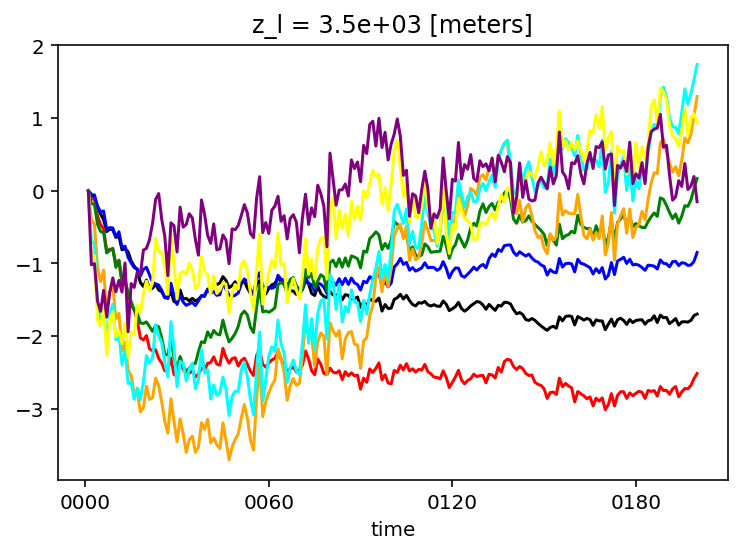

In [241]:
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=250).plot(color='black')
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=500).plot(color='red')
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=1000).plot(color='blue')
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=1500,method='nearest').plot(color='green')
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=2000,method='nearest').plot(color='orange')
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=2500,method='nearest').plot(color='cyan')
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=3000,method='nearest').plot(color='yellow')
odiv_183_184_depth_ann_diff_rel_yr_1.sel(z_l=3500,method='nearest').plot(color='purple')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

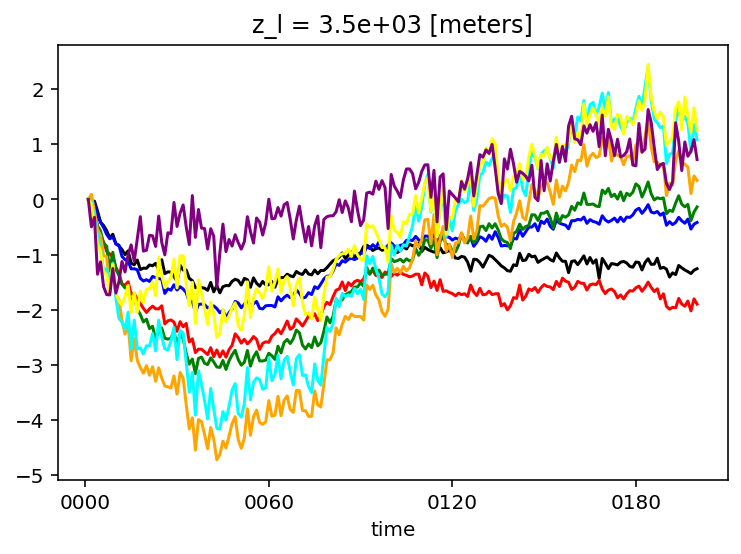

In [242]:
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=250).plot(color='black')
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=500).plot(color='red')
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=1000).plot(color='blue')
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=1500,method='nearest').plot(color='green')
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=2000,method='nearest').plot(color='orange')
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=2500,method='nearest').plot(color='cyan')
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=3000,method='nearest').plot(color='yellow')
odiv_170_depth_ann_diff_rel_yr_1.sel(z_l=3500,method='nearest').plot(color='purple')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

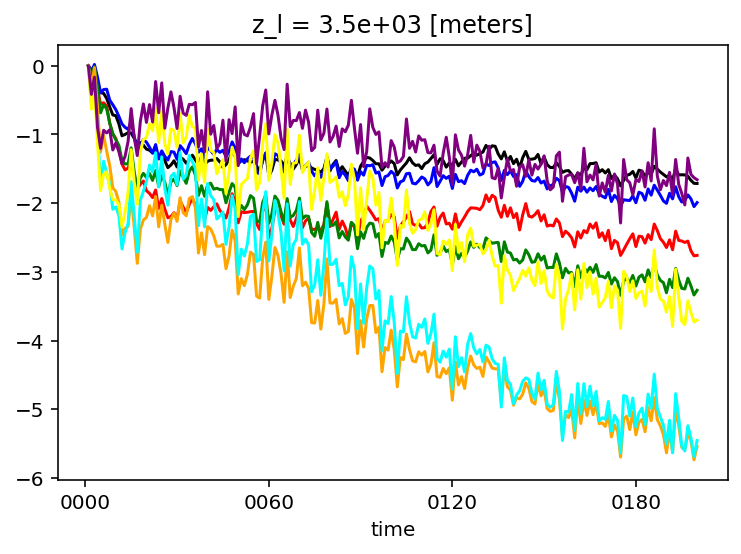

In [243]:
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=250).plot(color='black')
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=500).plot(color='red')
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=1000).plot(color='blue')
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=1500,method='nearest').plot(color='green')
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=2000,method='nearest').plot(color='orange')
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=2500,method='nearest').plot(color='cyan')
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=3000,method='nearest').plot(color='yellow')
odiv_200_depth_ann_diff_rel_yr_1.sel(z_l=3500,method='nearest').plot(color='purple')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

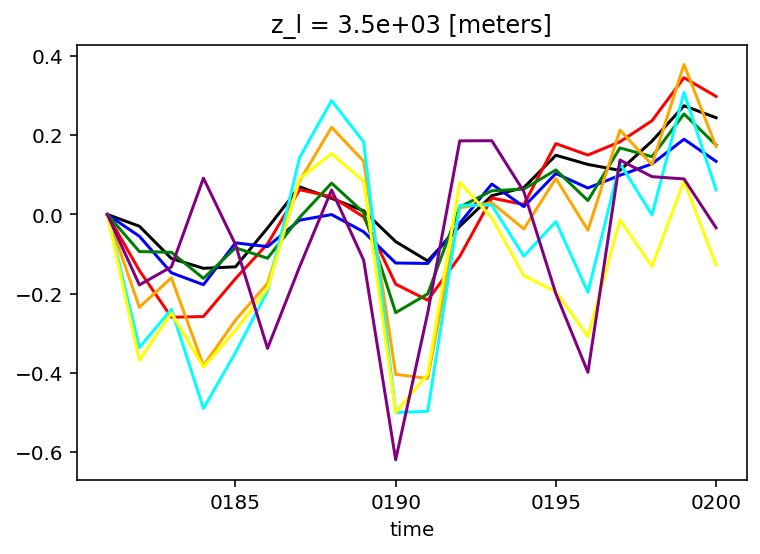

In [250]:
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=250).plot(color='black')
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=500).plot(color='red')
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=1000).plot(color='blue')
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=1500,method='nearest').plot(color='green')
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=2000,method='nearest').plot(color='orange')
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=2500,method='nearest').plot(color='cyan')
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=3000,method='nearest').plot(color='yellow')
odiv_206_depth_ann_diff_rel_yr_1.sel(z_l=3500,method='nearest').plot(color='purple')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

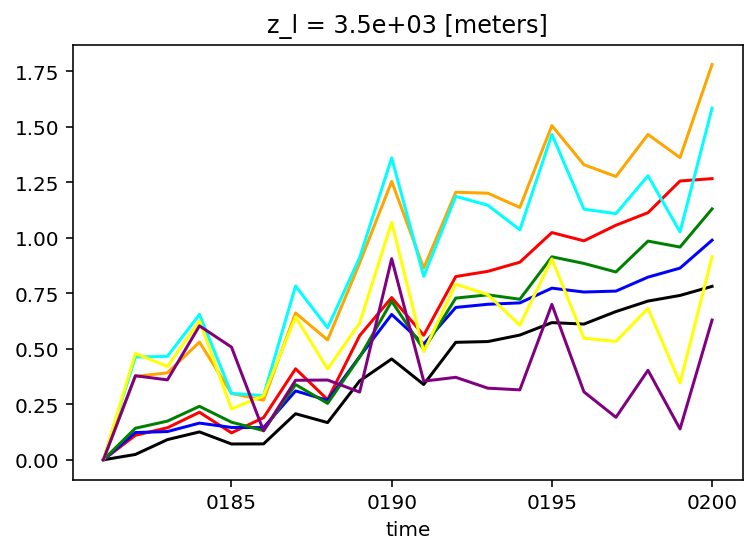

In [251]:
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=250).plot(color='black')
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=500).plot(color='red')
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=1000).plot(color='blue')
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=1500,method='nearest').plot(color='green')
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=2000,method='nearest').plot(color='orange')
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=2500,method='nearest').plot(color='cyan')
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=3000,method='nearest').plot(color='yellow')
odiv_207_depth_ann_diff_rel_yr_1.sel(z_l=3500,method='nearest').plot(color='purple')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

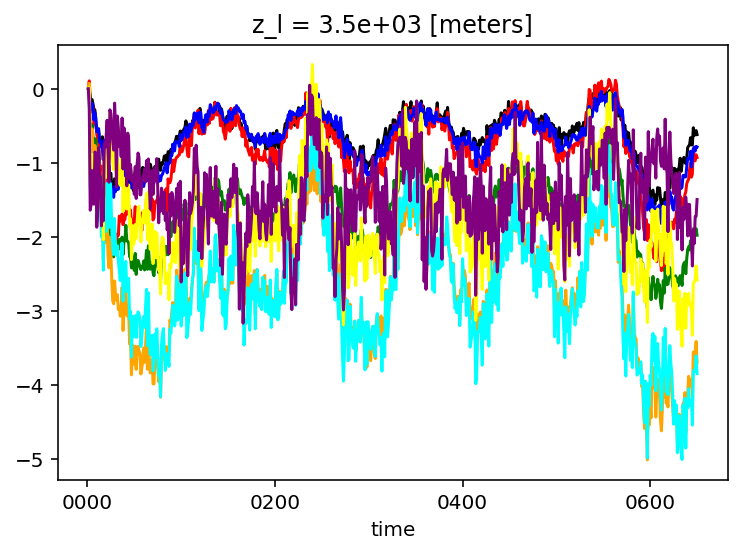

In [9]:
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=250).plot(color='black')
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=500).plot(color='red')
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=1000).plot(color='blue')
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=1500,method='nearest').plot(color='green')
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=2000,method='nearest').plot(color='orange')
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=2500,method='nearest').plot(color='cyan')
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=3000,method='nearest').plot(color='yellow')
cmip6_cm4_depth_ann_diff_rel_yr_1.sel(z_l=3500,method='nearest').plot(color='purple')

Text(0.5, 1.0, '181 to 200 ave')

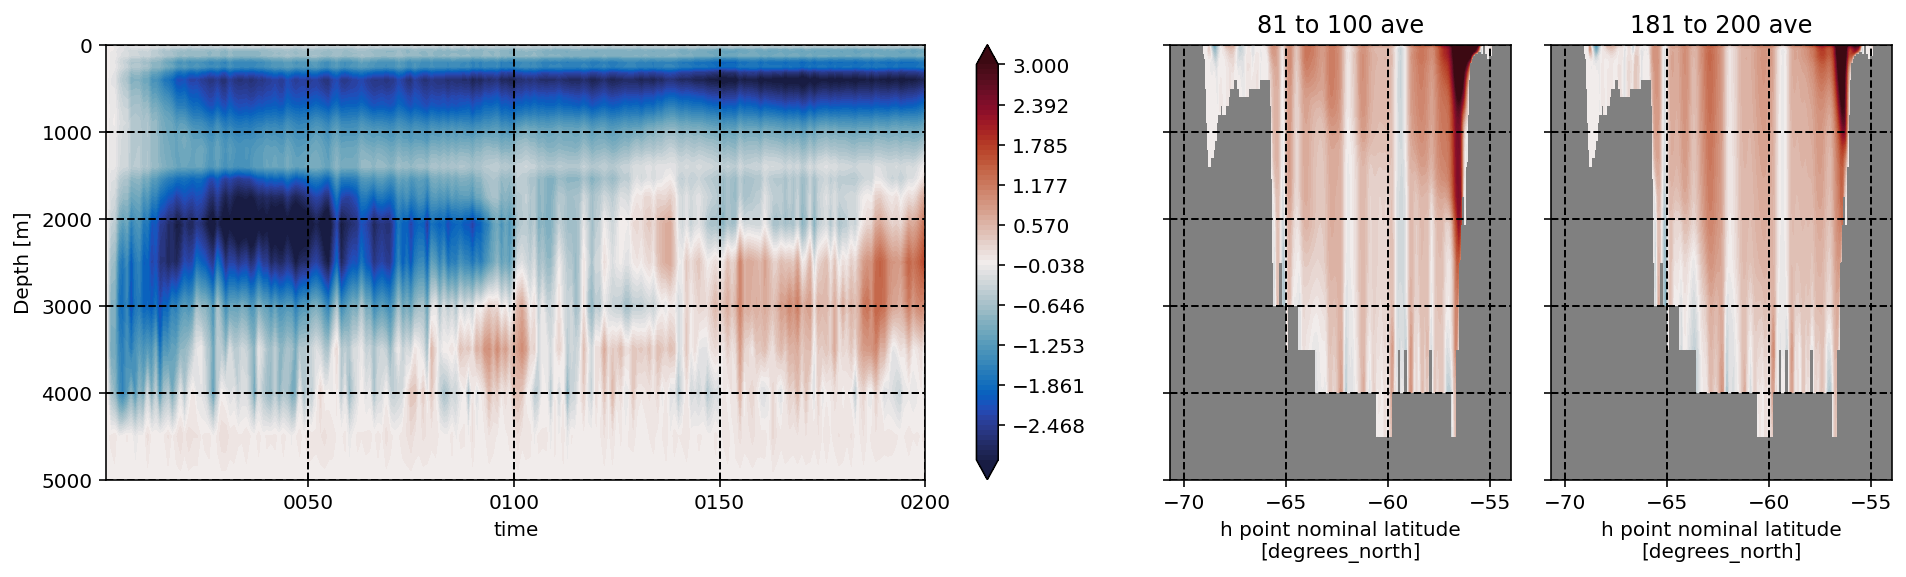

In [ ]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1], wspace=0.07) 
ax0 = plt.subplot(gs[0],facecolor='grey')
ax1 = plt.subplot(gs[1],facecolor='grey')
ax2 = plt.subplot(gs[2],facecolor='grey')



levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_183_184_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax0,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_183_184_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax2,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False)
odiv_183_184_uo.sel(time=slice('0081-01-16','0100-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False)

ax0.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax2.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

ax0.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax2.set_ylabel('')
                                           
ax1.set_title('81 to 100 ave')
ax2.set_title('181 to 200 ave')

Text(0.5, 1.0, '')

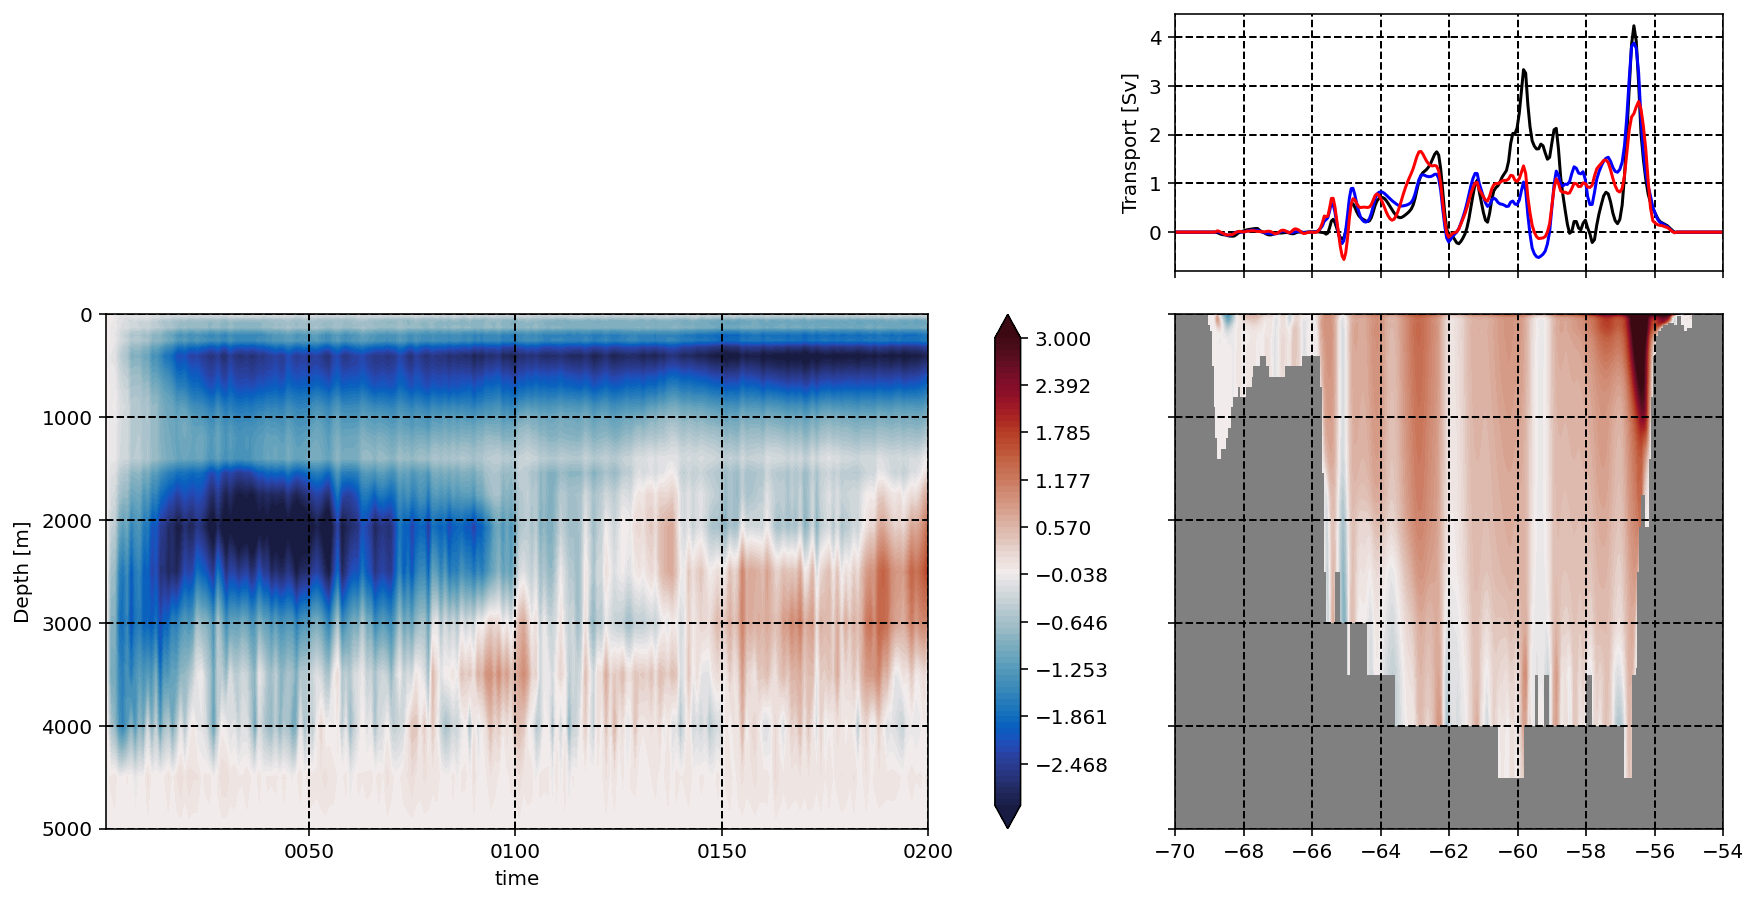

In [239]:
fig = plt.figure(constrained_layout=True,figsize=(14,8))
gs = fig.add_gridspec(nrows=4, ncols=6,
                      hspace=0.1, wspace=0.001)
ax1 = fig.add_subplot(gs[1:3, 3:5],facecolor='grey')
ax3 = fig.add_subplot(gs[1:3, :-3],facecolor='grey')
ax4 = fig.add_subplot(gs[0,3:5])

levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_183_184_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax3,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_183_184_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False,
                                                                                          xlim=(-70,-54))



odiv_183_184_lat_ann.sel(time=slice('0001-01-01','0020-01-01')).mean(dim='time').plot(ax=ax4,color='black',xlim=(-70,-54))
odiv_183_184_lat_ann.sel(time=slice('0081-01-01','0100-01-01')).mean(dim='time').plot(color='blue',xlim=(-70,-54))
odiv_183_184_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='red',xlim=(-70,-54))

ax4.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax3.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax4.xaxis.set_ticklabels([])

ax3.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax4.set_ylabel('Transport [Sv]')

ax3.set_xlabel('time')
ax1.set_xlabel('')
ax4.set_xlabel('')
                                           
ax1.set_title('')
ax3.set_title('')
ax4.set_title('')

Text(0.5, 1.0, '')

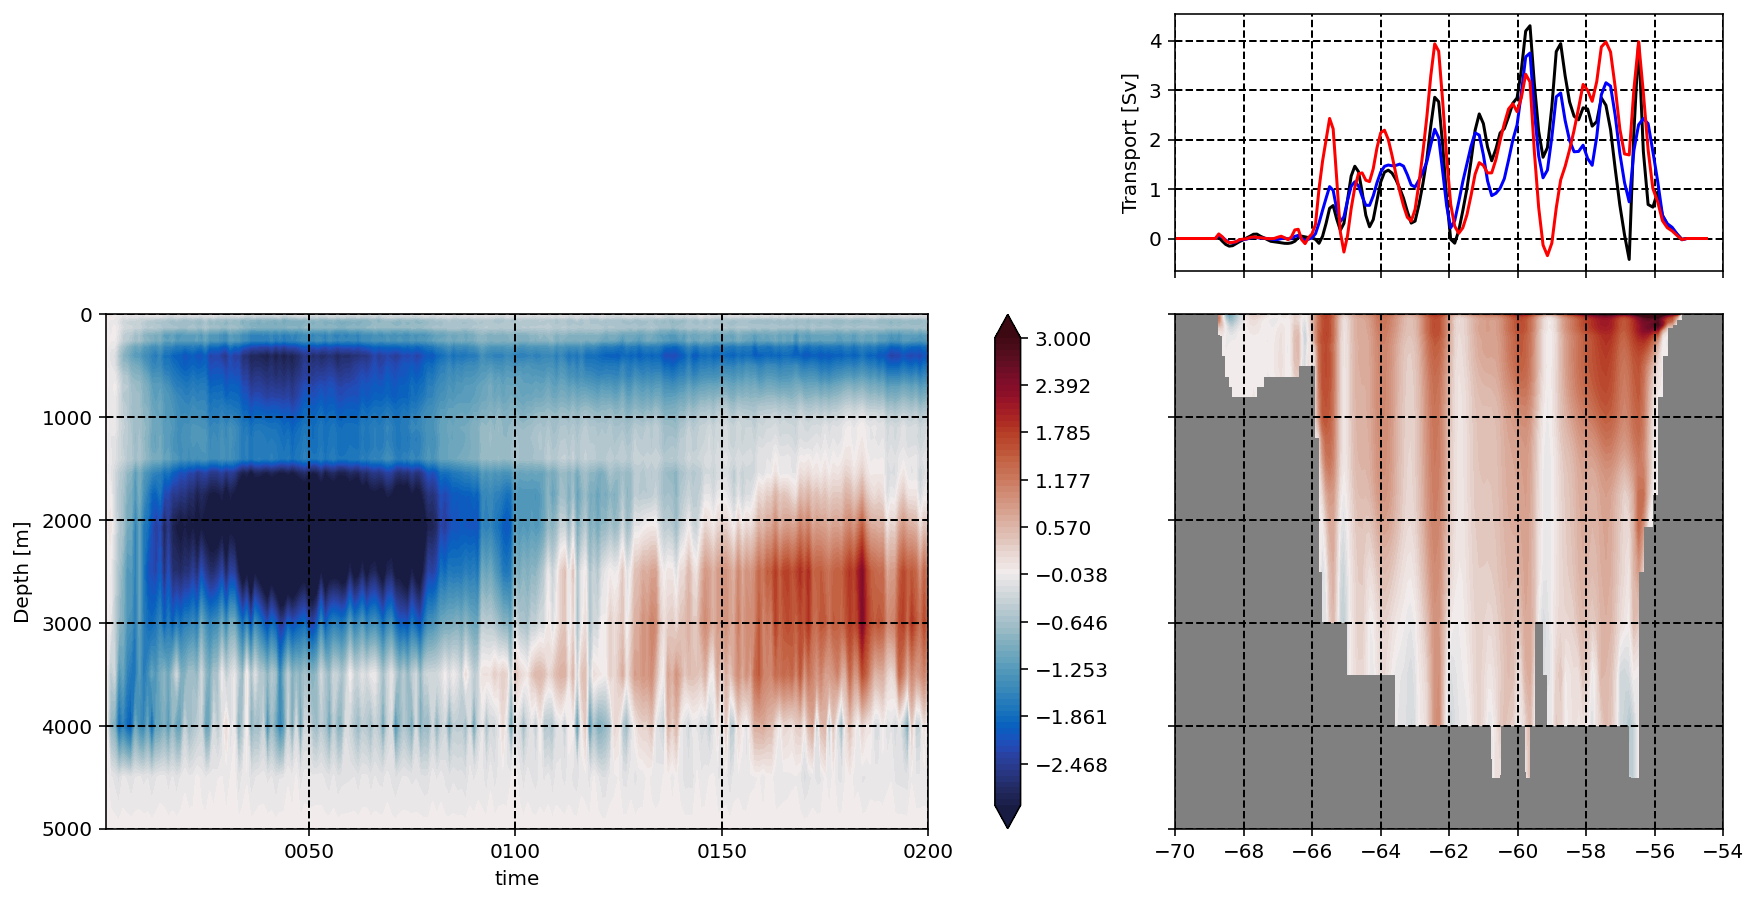

In [238]:
fig = plt.figure(constrained_layout=True,figsize=(14,8))
gs = fig.add_gridspec(nrows=4, ncols=6,
                      hspace=0.1, wspace=0.001)
ax1 = fig.add_subplot(gs[1:3, 3:5],facecolor='grey')
ax3 = fig.add_subplot(gs[1:3, :-3],facecolor='grey')
ax4 = fig.add_subplot(gs[0,3:5])

levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_170_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax3,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_170_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False,
                                                                                          xlim=(-70,-54))



odiv_170_lat_ann.sel(time=slice('0001-01-01','0020-01-01')).mean(dim='time').plot(ax=ax4,color='black',xlim=(-70,-54))
odiv_170_lat_ann.sel(time=slice('0081-01-01','0100-01-01')).mean(dim='time').plot(color='blue',xlim=(-70,-54))
odiv_170_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='red',xlim=(-70,-54))

ax4.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax3.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax4.xaxis.set_ticklabels([])

ax3.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax4.set_ylabel('Transport [Sv]')

ax3.set_xlabel('time')
ax1.set_xlabel('')
ax4.set_xlabel('')
                                           
ax1.set_title('')
ax3.set_title('')
ax4.set_title('')

Text(0.5, 1.0, '')

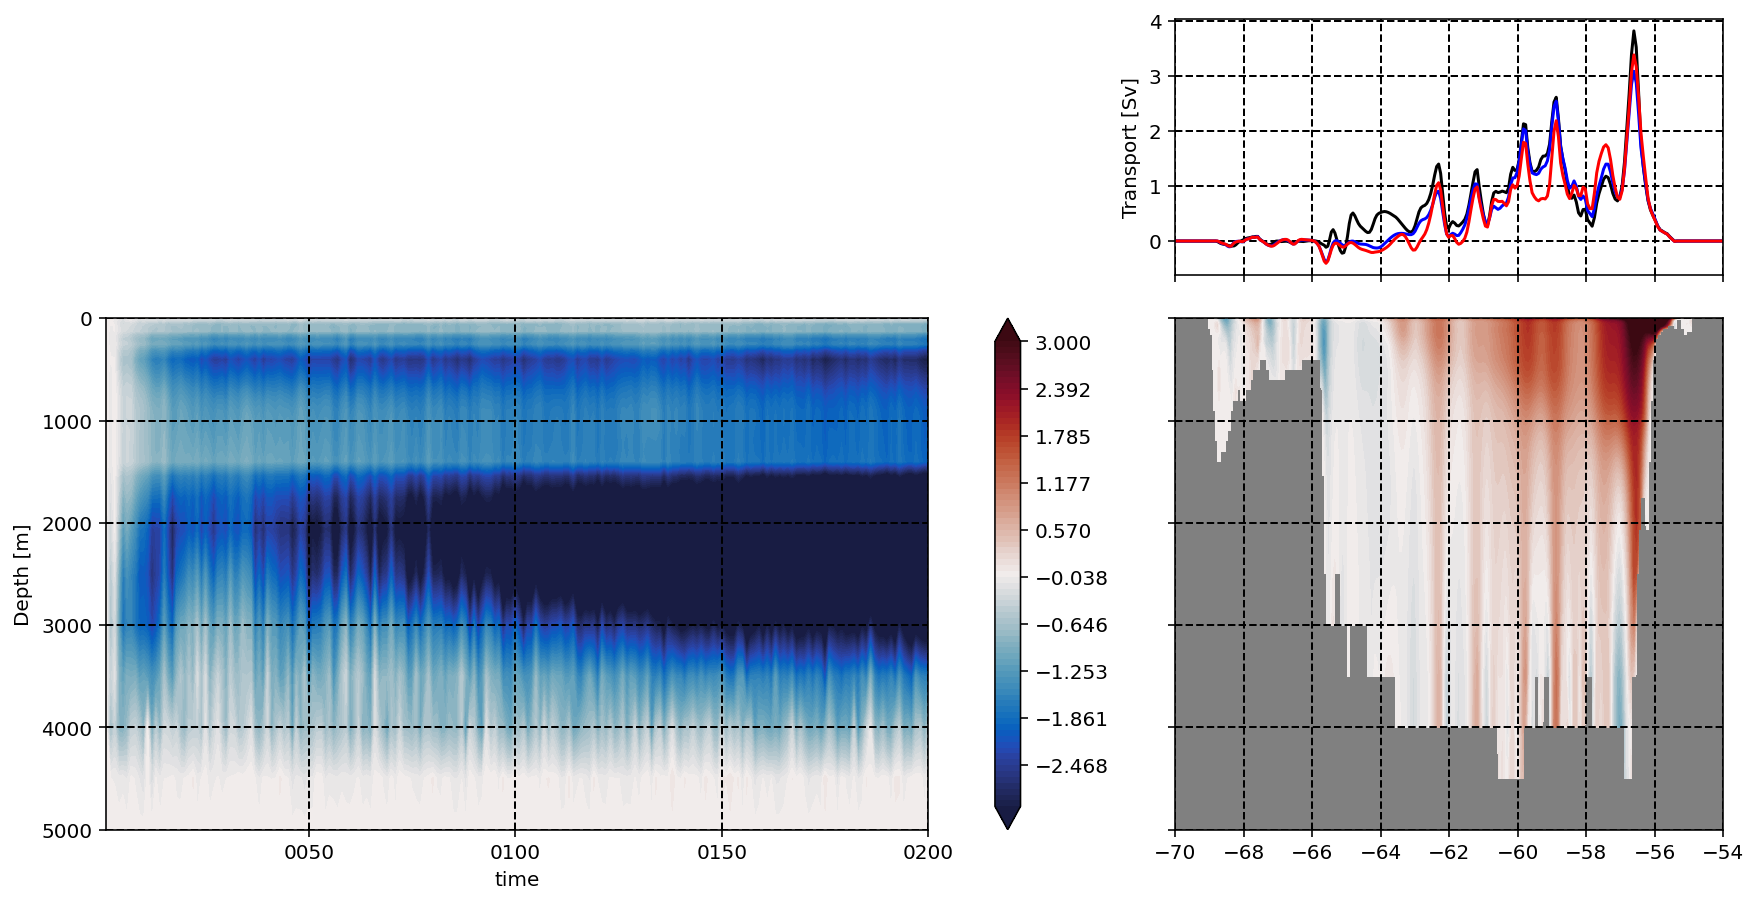

In [240]:
fig = plt.figure(constrained_layout=True,figsize=(14,8))
gs = fig.add_gridspec(nrows=4, ncols=6,
                      hspace=0.1, wspace=0.001)
ax1 = fig.add_subplot(gs[1:3, 3:5],facecolor='grey')
ax3 = fig.add_subplot(gs[1:3, :-3],facecolor='grey')
ax4 = fig.add_subplot(gs[0,3:5])

levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_200_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax3,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_200_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False,
                                                                                          xlim=(-70,-54))



odiv_200_lat_ann.sel(time=slice('0001-01-01','0020-01-01')).mean(dim='time').plot(ax=ax4,color='black',xlim=(-70,-54))
odiv_200_lat_ann.sel(time=slice('0081-01-01','0100-01-01')).mean(dim='time').plot(color='blue',xlim=(-70,-54))
odiv_200_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='red',xlim=(-70,-54))

ax4.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax3.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax4.xaxis.set_ticklabels([])

ax3.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax4.set_ylabel('Transport [Sv]')

ax3.set_xlabel('time')
ax1.set_xlabel('')
ax4.set_xlabel('')
                                           
ax1.set_title('')
ax3.set_title('')
ax4.set_title('')

Text(0.5, 1.0, '')

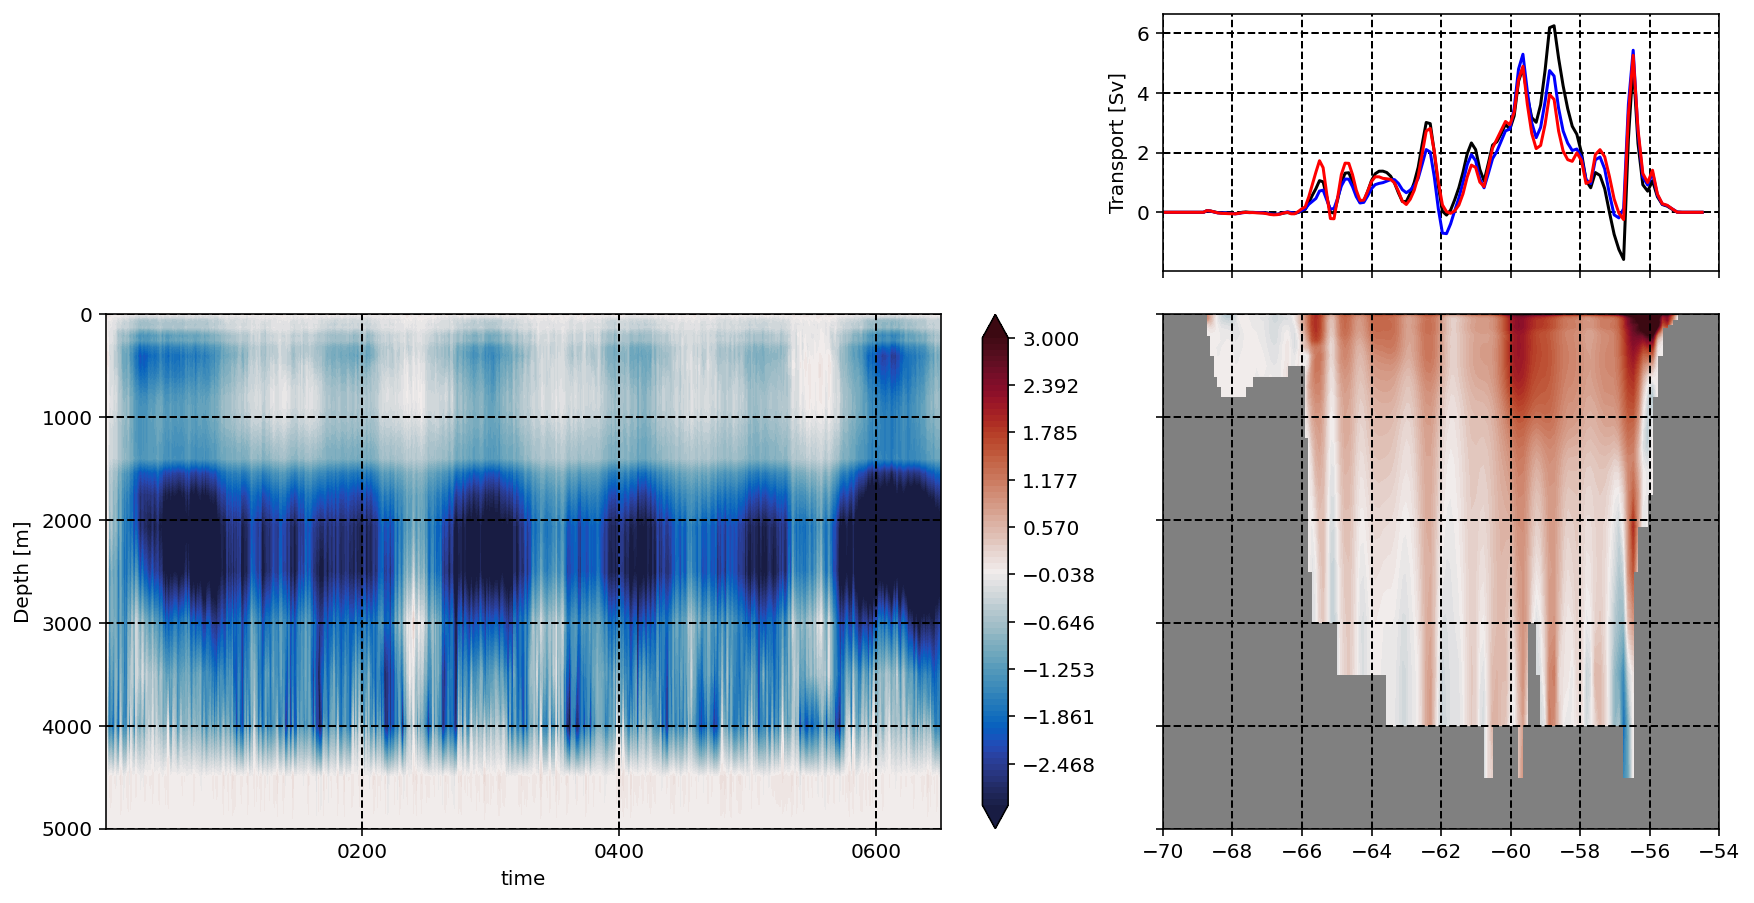

In [10]:
fig = plt.figure(constrained_layout=True,figsize=(14,8))
gs = fig.add_gridspec(nrows=4, ncols=6,
                      hspace=0.1, wspace=0.001)
ax1 = fig.add_subplot(gs[1:3, 3:5],facecolor='grey')
ax3 = fig.add_subplot(gs[1:3, :-3],facecolor='grey')
ax4 = fig.add_subplot(gs[0,3:5])

levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

cmip6_cm4_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax3,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

cmip6_cm4_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False,
                                                                                          xlim=(-70,-54))



cmip6_cm4_lat_ann.sel(time=slice('0001-01-01','0020-01-01')).mean(dim='time').plot(ax=ax4,color='black',xlim=(-70,-54))
cmip6_cm4_lat_ann.sel(time=slice('0081-01-01','0100-01-01')).mean(dim='time').plot(color='blue',xlim=(-70,-54))
cmip6_cm4_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='red',xlim=(-70,-54))

ax4.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax3.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax4.xaxis.set_ticklabels([])

ax3.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax4.set_ylabel('Transport [Sv]')

ax3.set_xlabel('time')
ax1.set_xlabel('')
ax4.set_xlabel('')
                                           
ax1.set_title('')
ax3.set_title('')
ax4.set_title('')

Text(0.5, 1.0, '')

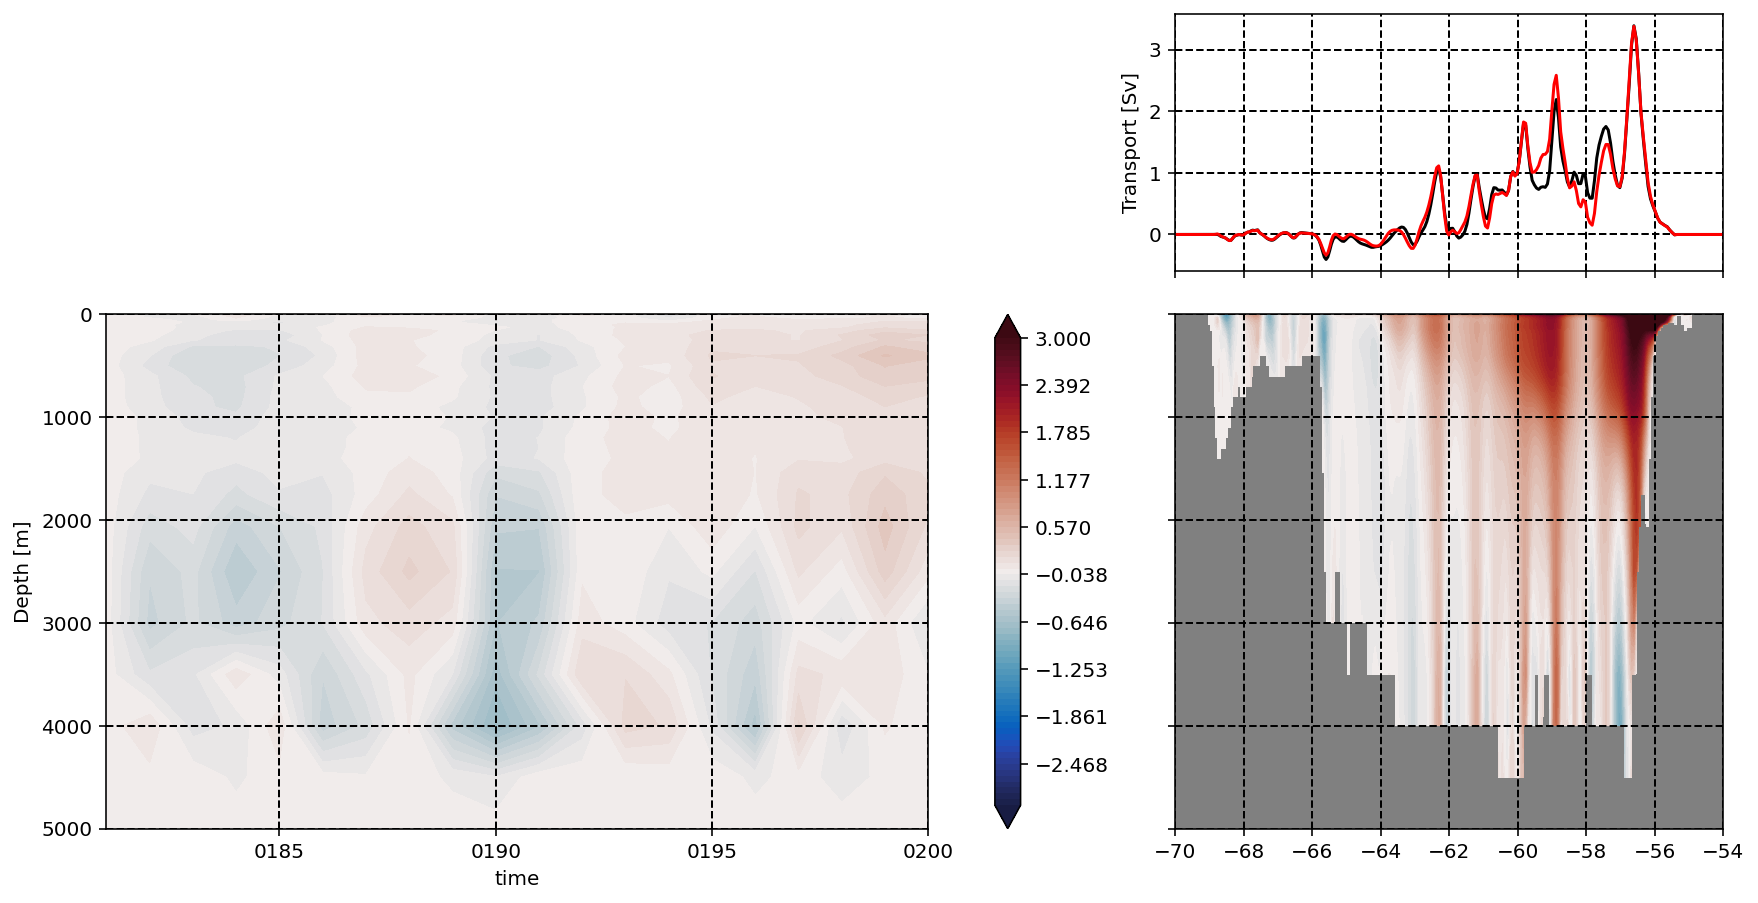

In [252]:
fig = plt.figure(constrained_layout=True,figsize=(14,8))
gs = fig.add_gridspec(nrows=4, ncols=6,
                      hspace=0.1, wspace=0.001)
ax1 = fig.add_subplot(gs[1:3, 3:5],facecolor='grey')
ax3 = fig.add_subplot(gs[1:3, :-3],facecolor='grey')
ax4 = fig.add_subplot(gs[0,3:5])

levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_206_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax3,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_206_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False,
                                                                                          xlim=(-70,-54))



odiv_200_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='black',xlim=(-70,-54))
odiv_206_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='red',xlim=(-70,-54))

ax4.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax3.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax4.xaxis.set_ticklabels([])

ax3.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax4.set_ylabel('Transport [Sv]')

ax3.set_xlabel('time')
ax1.set_xlabel('')
ax4.set_xlabel('')
                                           
ax1.set_title('')
ax3.set_title('')
ax4.set_title('')

Text(0.5, 1.0, '')

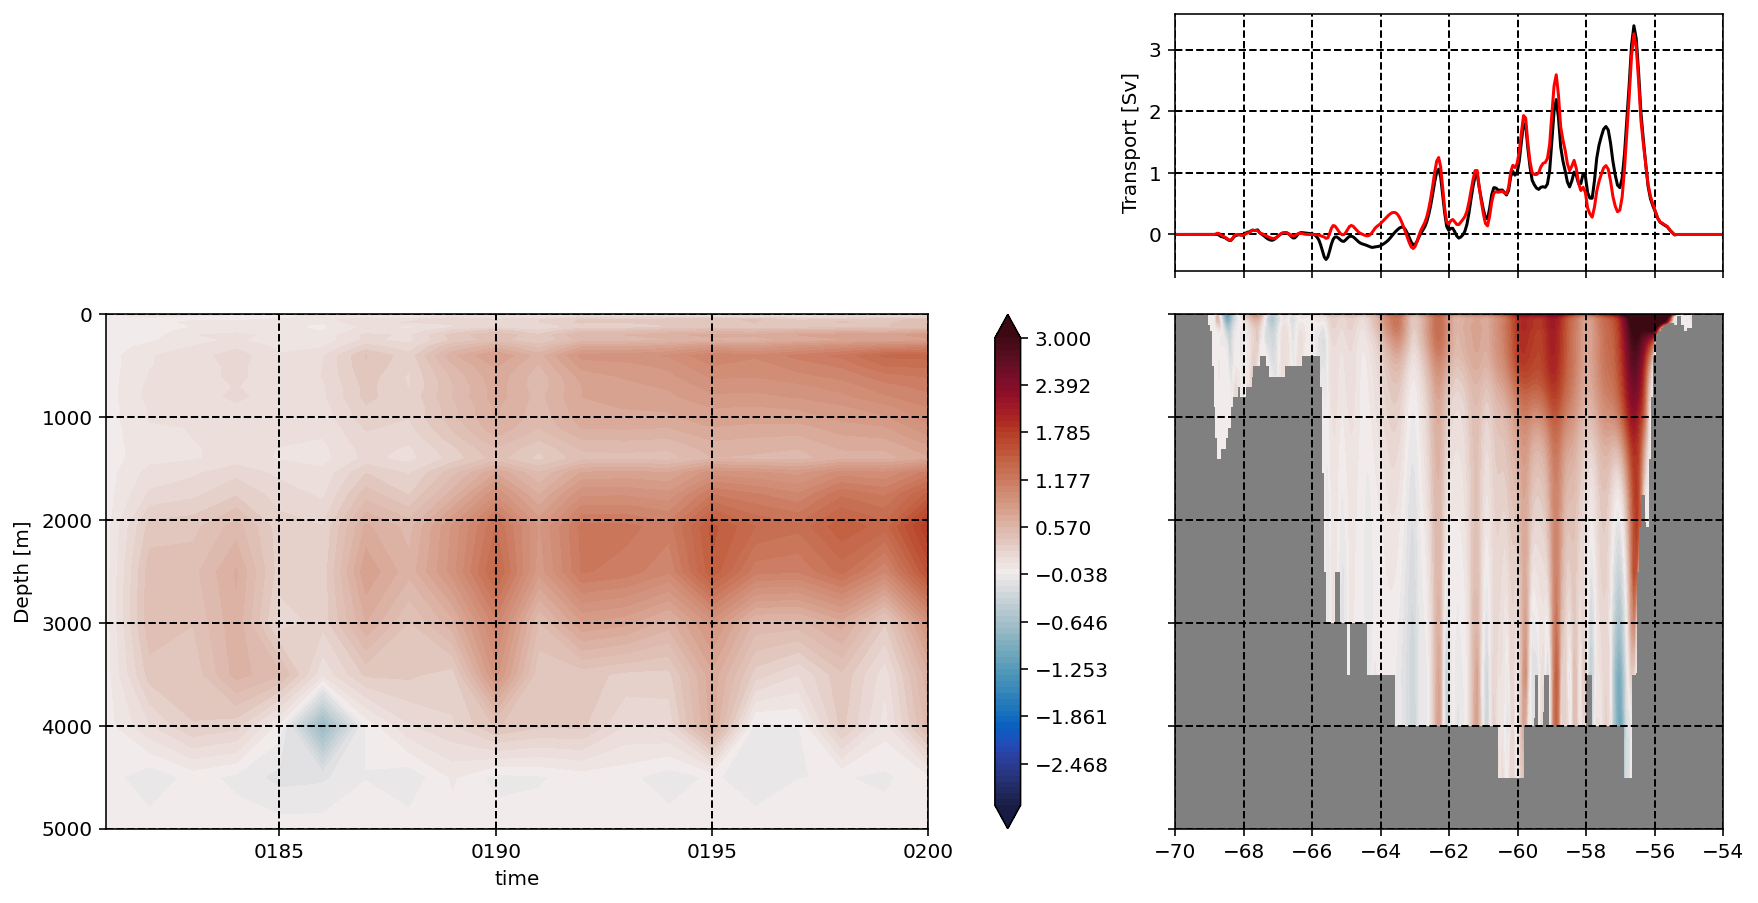

In [253]:
fig = plt.figure(constrained_layout=True,figsize=(14,8))
gs = fig.add_gridspec(nrows=4, ncols=6,
                      hspace=0.1, wspace=0.001)
ax1 = fig.add_subplot(gs[1:3, 3:5],facecolor='grey')
ax3 = fig.add_subplot(gs[1:3, :-3],facecolor='grey')
ax4 = fig.add_subplot(gs[0,3:5])

levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_207_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax3,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_207_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False,
                                                                                          xlim=(-70,-54))



odiv_200_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='black',xlim=(-70,-54))
odiv_207_lat_ann.sel(time=slice('0181-01-01','0200-01-01')).mean(dim='time').plot(color='red',xlim=(-70,-54))

ax4.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax3.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax4.xaxis.set_ticklabels([])

ax3.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax4.set_ylabel('Transport [Sv]')

ax3.set_xlabel('time')
ax1.set_xlabel('')
ax4.set_xlabel('')
                                           
ax1.set_title('')
ax3.set_title('')
ax4.set_title('')

Text(0.5, 1.0, '181 to 200 ave')

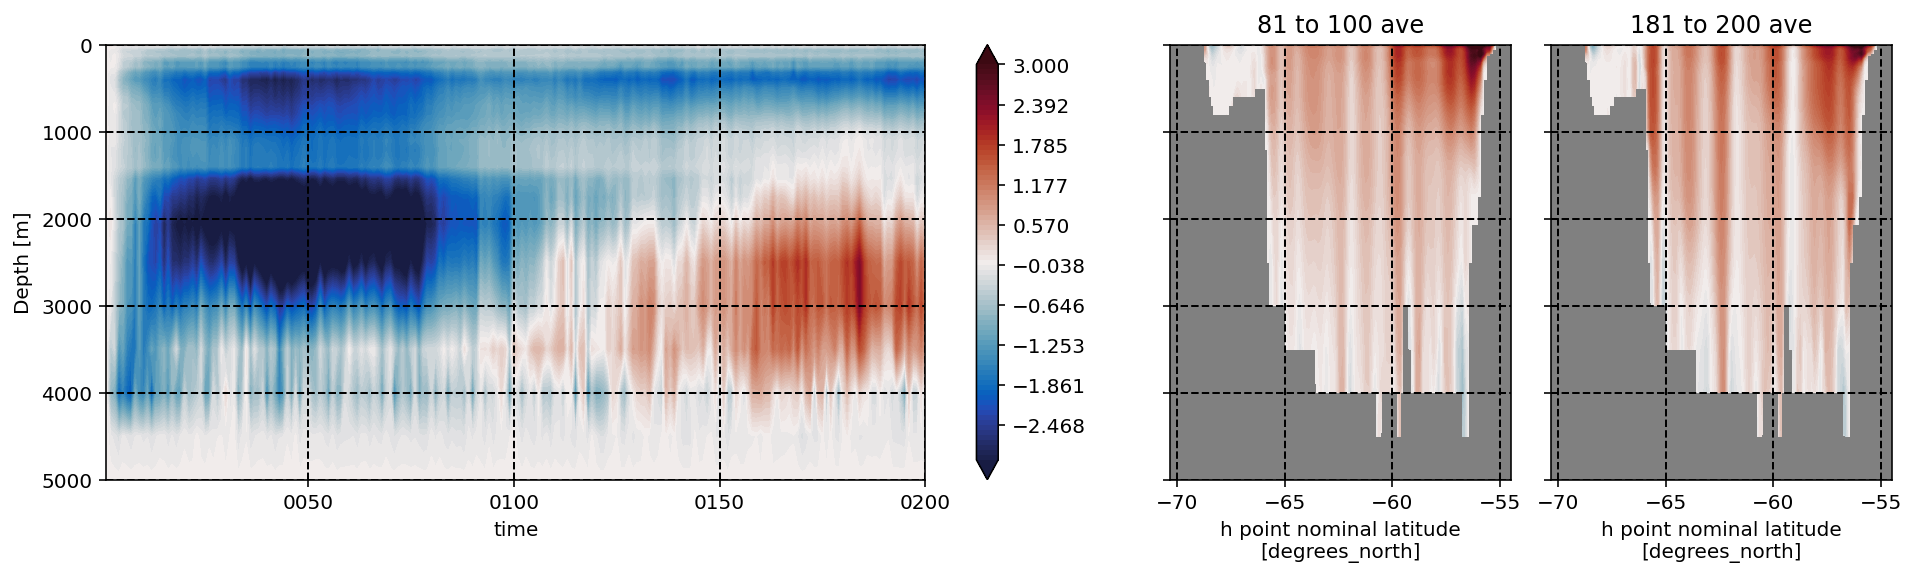

In [51]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1], wspace=0.07) 
ax0 = plt.subplot(gs[0],facecolor='grey')
ax1 = plt.subplot(gs[1],facecolor='grey')
ax2 = plt.subplot(gs[2],facecolor='grey')



levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_170_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax0,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_170_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax2,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False)
odiv_170_uo.sel(time=slice('0081-01-16','0100-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False)

ax0.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax2.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

ax0.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax2.set_ylabel('')
                                           
ax1.set_title('81 to 100 ave')
ax2.set_title('181 to 200 ave')

Text(0.5, 1.0, '181 to 200 ave')

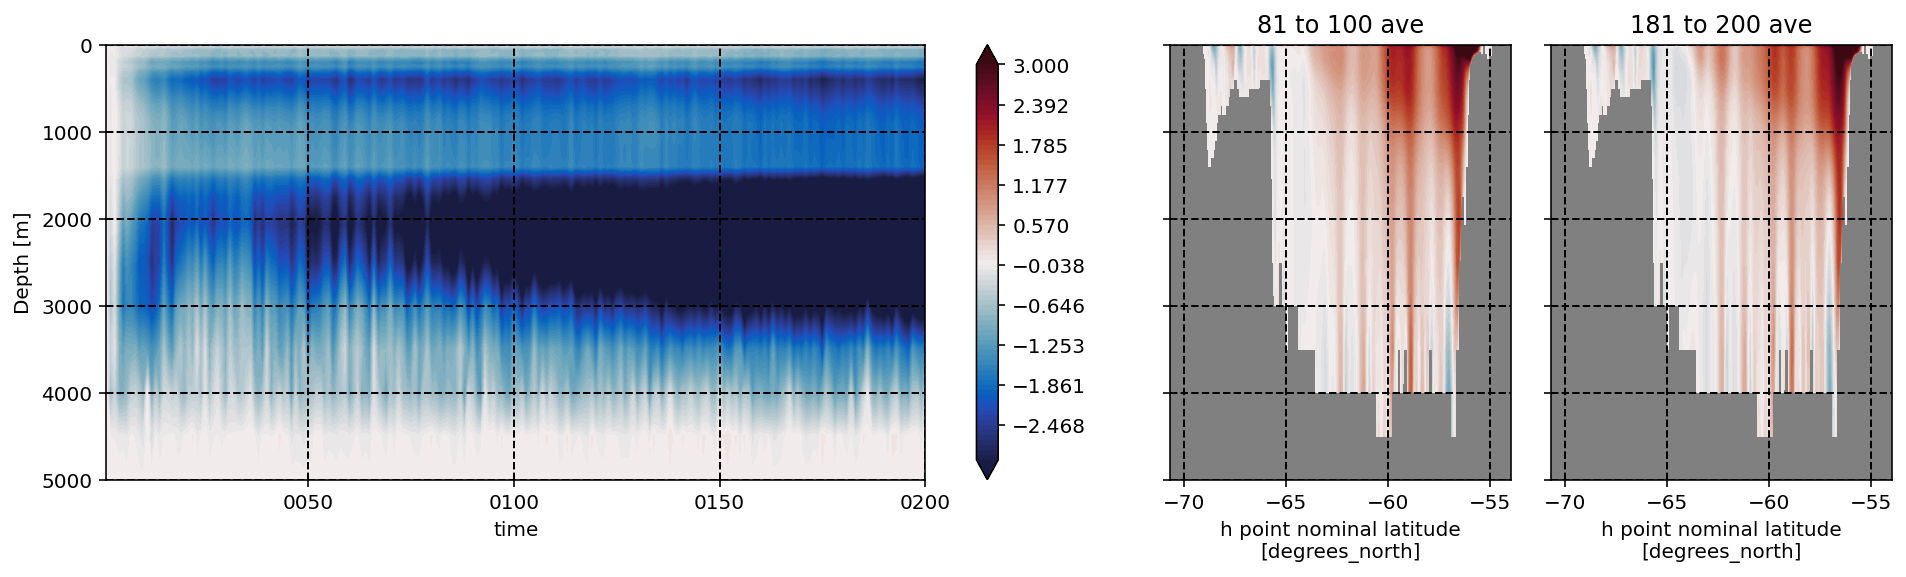

In [53]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1], wspace=0.07) 
ax0 = plt.subplot(gs[0],facecolor='grey')
ax1 = plt.subplot(gs[1],facecolor='grey')
ax2 = plt.subplot(gs[2],facecolor='grey')



levels_diff = np.linspace(-3,3,80)
levels_vel = np.linspace(-0.20,0.20,80)

odiv_200_depth_ann_diff_rel_yr_1.plot.contourf(ax=ax0,y='z_l',
                                 yincrease=False,
                                 levels=levels_diff,
                                 ylim=(5000,0),
                                 cmap=cmocean.cm.balance,
                                 extend='both')

odiv_200_uo.sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax2,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False)
odiv_200_uo.sel(time=slice('0081-01-16','0100-12-16')).mean(dim='time').squeeze().plot.contourf(ax=ax1,
                                                                                          yincrease=False,
                                                                                          ylim=(5000,0),
                                                                                          levels=levels_vel,
                                                                                          extend='both',
                                                                                          cmap=cmocean.cm.balance,
                                                                                          corner_mask=False,
                                                                                          add_colorbar=False)

ax0.grid(linestyle='--',linewidth=1, color='black')
ax1.grid(linestyle='--',linewidth=1, color='black')
ax2.grid(linestyle='--',linewidth=1, color='black')

ax1.yaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

ax0.set_ylabel('Depth [m]')
ax1.set_ylabel('')
ax2.set_ylabel('')
                                           
ax1.set_title('81 to 100 ave')
ax2.set_title('181 to 200 ave')